In [1]:
import tensorflow as tf
msg = tf.constant('Hello, TensorFlow!')
tf.print(msg)

Hello, TensorFlow!


In [457]:
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from matplotlib import pyplot as plt

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

plt.rcParams["figure.figsize"] = [16, 12]

print("pandas Version: " + pd.__version__)
print("numpy Version: " + np.__version__)
print("statsmodels Version: " + sm.__version__)

pandas Version: 1.2.4
numpy Version: 1.18.5
statsmodels Version: 0.12.2


In [474]:
# Make cells wider and figures larger
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:70% !important; }</style>"))
plt.rcParams["figure.figsize"] = (25,10)

In [4]:
# Switch between recalculating or reading from file to save time

READ_ADF_RESULTS_FROM_FILE = True

In [5]:
df = pd.read_csv("../data/clean/station_trips_weather.csv", parse_dates=["datetime"])
df.set_index("datetime", inplace=True)
df["station_name"] = df["station_name"].astype("category")

In [6]:
df.head(3)

,station_name,check_ins,check_outs,diff,precip_intensity,precip_probability,precip_type,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility
datetime,,,,,,,,,,,,,
2014-01-01,Allende-Platz/Grindelhof,0,5,-5,0.0,0.0,none,1.93,0.81,3.91,161.0,0.0,9.988
2014-01-01,Alsenstraße/Düppelstraße,3,0,3,0.0,0.0,none,1.93,0.81,3.91,161.0,0.0,9.988
2014-01-01,Alsterdorf Markt/Evangelische Stiftung,0,0,0,0.0,0.0,none,1.93,0.81,3.91,161.0,0.0,9.988


In [7]:
df.tail(3)

,station_name,check_ins,check_outs,diff,precip_intensity,precip_probability,precip_type,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility
datetime,,,,,,,,,,,,,
2017-05-15 11:00:00,Winterhuder Weg/ Zimmerstraße,2,4,-2,0.0,0.0,none,14.02,0.71,3.49,276.0,4.0,10.003
2017-05-15 11:00:00,Zentralbibliothek / Münzstraße,0,2,-2,0.0,0.0,none,14.02,0.71,3.49,276.0,4.0,10.003
2017-05-15 11:00:00,Überseering/Mexikoring,1,1,0,0.0,0.0,none,14.02,0.71,3.49,276.0,4.0,10.003


In [8]:
stations = pd.read_csv("../data/clean/stations.csv")
stations.sample(3)

,station_id,name,longitude,latitude
44,138380,Jungfernstieg / Neuer Jungfernstieg,9.991400,53.555000
55,140790,Hammerbrook / Sachsenfeld,10.024042,53.546011
76,198086,Eppendorfer Weg/Hoheluftchaussee,9.971720,53.581771


## Building an ARIMA model

### Examine stationarity

In [ ]:
number_of_examples = 5
sample_stations = stations.sample(number_of_examples)["name"].values

#title = "Difference of check-in and check-out: {name}"
fig = make_subplots(
    rows=number_of_examples, 
    cols=1, 
    shared_yaxes=True, 
    x_title="Date",
    y_title="Inventory difference"
)

row = 1
for sample_station in sample_stations:
    sample_slice = df[df.station_name == sample_station]
    trace = go.Scatter(
        x=sample_slice.index,
        y=sample_slice["diff"],
        mode="lines",
        name=sample_station
    )
    fig.append_trace(trace, row=row, col=1)
    row = row + 1

fig.show()

In [ ]:
number_of_examples = 5
sample_stations = stations.sample(number_of_examples)["name"].values

#title = "Difference of check-in and check-out: {name}"
fig = make_subplots(
    rows=number_of_examples, 
    cols=1, 
    shared_yaxes=True, 
    x_title="Date",
    y_title="Check-ins"
)

row = 1
for sample_station in sample_stations:
    sample_slice = df[df.station_name == sample_station]
    trace = go.Scatter(
        x=sample_slice.index,
        y=sample_slice["check_ins"],
        mode="lines",
        name=sample_station
    )
    fig.append_trace(trace, row=row, col=1)
    row = row + 1

fig.show()

**Step 1: Check if the data is stationary**

1. Test stationarity with the *Augmented Dickey-Fuller* test for every station individually
2. Collect the results in a dataframe with columns for 'ADF statistics', 'ADF p_value', 'ADF critvalue 1'
3. Add a 'stationary' column and set to True, if 'p_value' is lower than the threshold of 0.05 and the 'ADF statistics' value is negative and lower than the 'ADF critvalue 1' value, otherwise set to False
4. Examine rows where 'stationary' is set to False

In [ ]:
p_threshold = 0.05

def is_stationary(stats, p_value, crit1):
    return (
        p_value < p_threshold
    ) and (
        (stats < 0) and (stats < crit1)
    )

In [ ]:
if READ_ADF_RESULTS_FROM_FILE:
    diff_adf_results = pd.read_csv("calculations/station_diff_adf_results.csv")
else:
    diff_adf_results = pd.DataFrame([], columns=["station_name", "stats", "p_value", "crit1"])

    for station in df.station_name.cat.categories:
        df_tmp = df[df.station_name == station]
        result = adfuller(df_tmp["diff"])
        diff_adf_results = diff_adf_results.append({
            "station_name": station,
            "stats": result[0],
            "p_value": result[1],
            "crit1": result[4]["1%"]
        }, ignore_index=True)
    
    diff_adf_results["stationary"] = diff_adf_results.apply(
        lambda x: is_stationary(x["stats"], x["p_value"], x["crit1"]), 
        axis=1
    )
    diff_adf_results.to_csv("calculations/station_diff_adf_results.csv", index=False)

In [ ]:
diff_adf_results

In [ ]:
diff_adf_results[diff_adf_results.stationary == False]

In [ ]:
diff_adf_results.describe()

The diff data is stationary for all stations and therefore does not require differenciation when predicting with an ARIMA model. Therefore the `d` parameter can be set to 0.

**Repeat for check ins**

In [ ]:
if READ_ADF_RESULTS_FROM_FILE:
    check_ins_adf_results = pd.read_csv("calculations/station_adf_results_check_ins.csv")
else:
    check_ins_adf_results = pd.DataFrame([], columns=["station_name", "stats", "p_value", "crit1"])

    for station in df.station_name.cat.categories:
        df_tmp = df[df.station_name == station]
        result = adfuller(df_tmp["check_ins"])
        check_ins_adf_results = check_ins_adf_results.append({
            "station_name": station,
            "stats": result[0],
            "p_value": result[1],
            "crit1": result[4]["1%"]
        }, ignore_index=True)
    
    check_ins_adf_results["stationary"] = check_ins_adf_results.apply(
        lambda x: is_stationary(x["stats"], x["p_value"], x["crit1"]), 
        axis=1
    )
    check_ins_adf_results.to_csv("calculations/station_adf_results_check_ins.csv", index=False)

In [ ]:
check_ins_adf_results[check_ins_adf_results.stationary == False]

In [ ]:
df[df.station_name == "Osterstraße/Heußweg"][["check_ins"]].plot()

**Repeat for check outs**

In [ ]:
if READ_ADF_RESULTS_FROM_FILE:
    check_outs_adf_results = pd.read_csv("calculations/station_adf_results_check_outs.csv")
else:
    check_outs_adf_results = pd.DataFrame([], columns=["station_name", "stats", "p_value", "crit1"])

    for station in df.station_name.cat.categories:
        df_tmp = df[df.station_name == station]
        result = adfuller(df_tmp["check_outs"])
        check_outs_adf_results = check_outs_adf_results.append({
            "station_name": station,
            "stats": result[0],
            "p_value": result[1],
            "crit1": result[4]["1%"]
        }, ignore_index=True)
    
    check_outs_adf_results["stationary"] = check_outs_adf_results.apply(
        lambda x: is_stationary(x["stats"], x["p_value"], x["crit1"]), 
        axis=1
    )
    check_outs_adf_results.to_csv("calculations/station_adf_results_check_outs.csv", index=False)

In [ ]:
check_outs_adf_results[check_outs_adf_results.stationary == False]

## Exploration

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

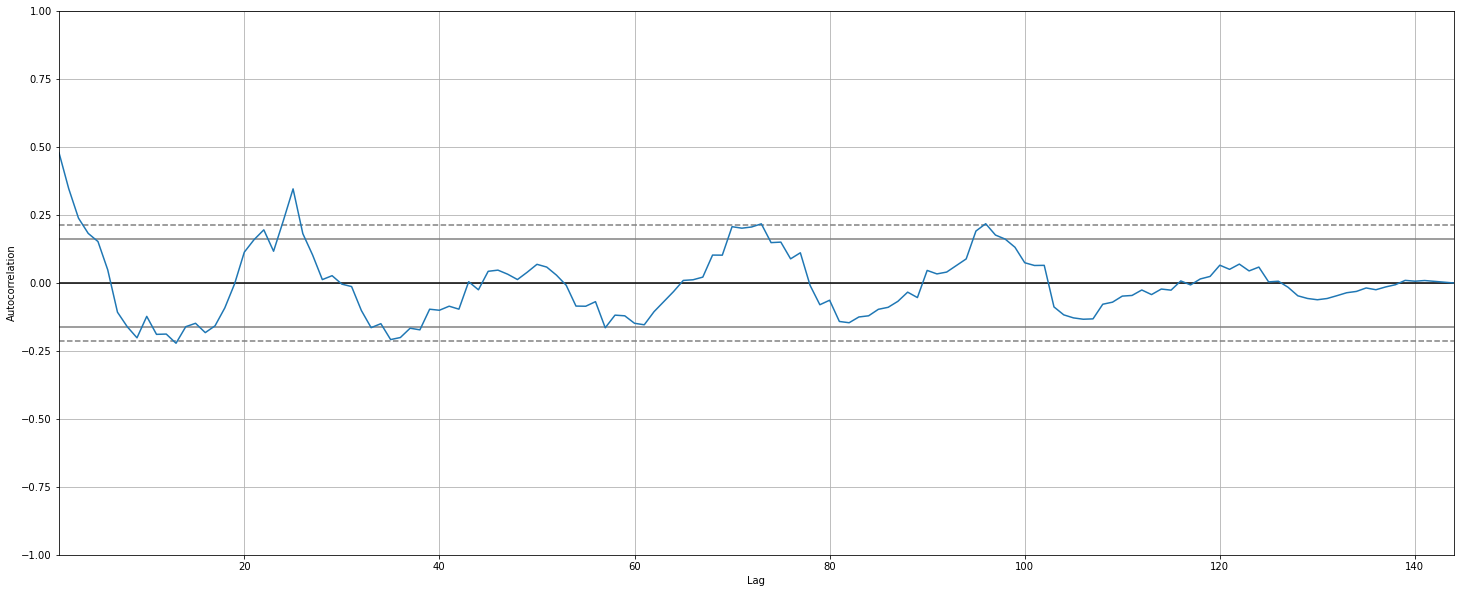

In [258]:
autocorrelation_plot(hourly_sample)

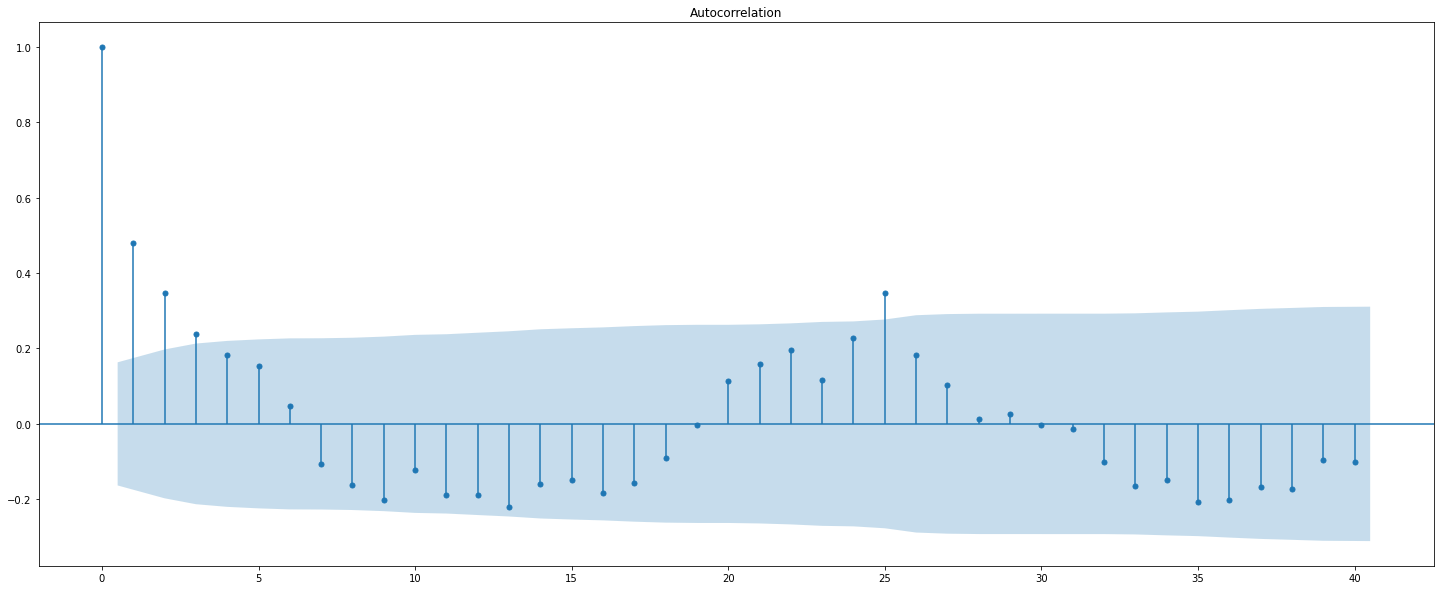

In [259]:
sm.graphics.tsa.plot_acf(hourly_sample, lags=40)
plt.show()

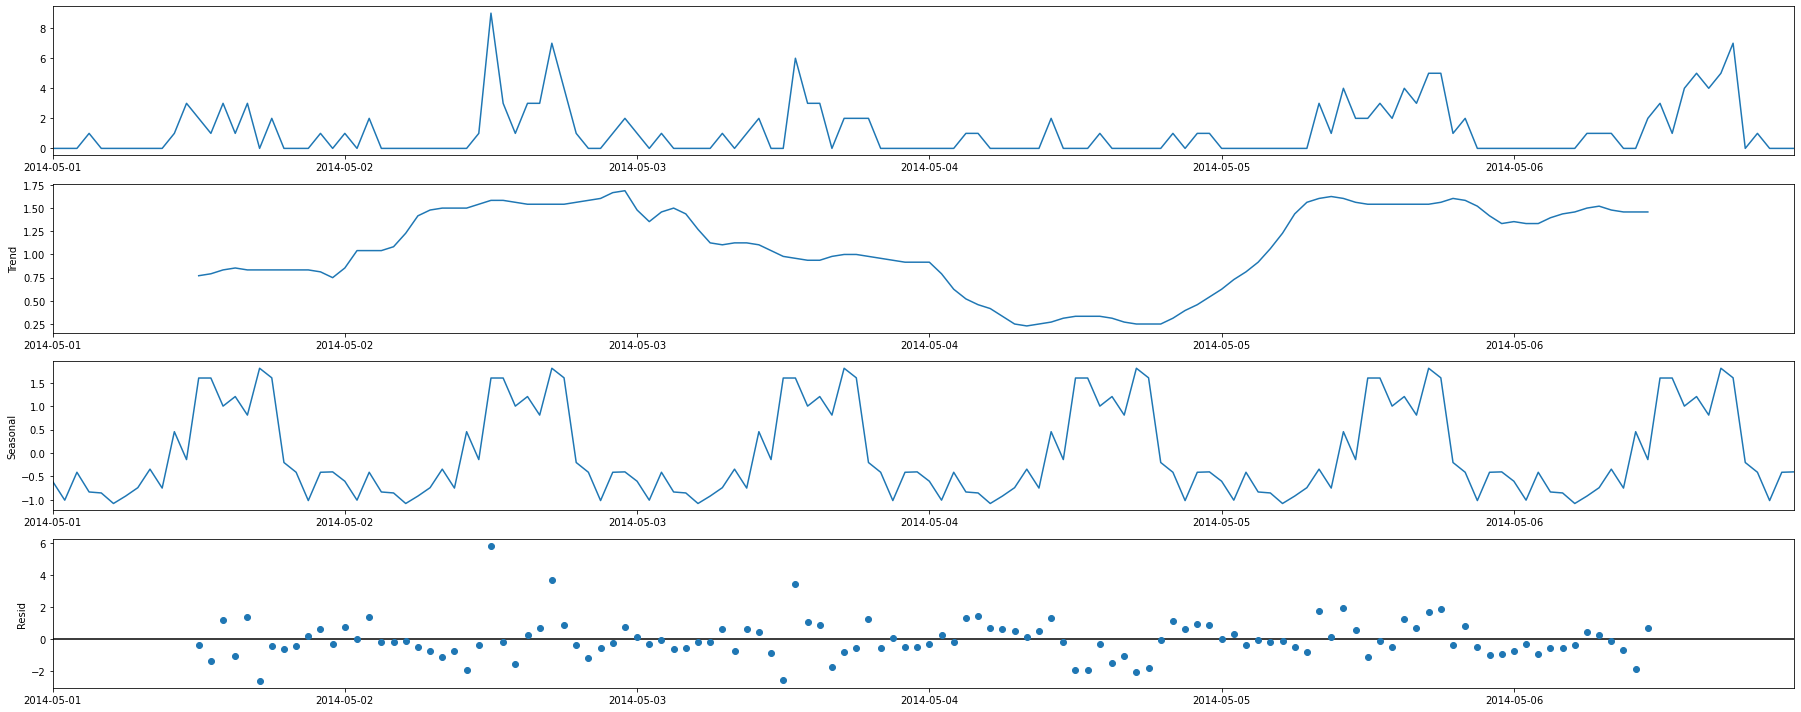

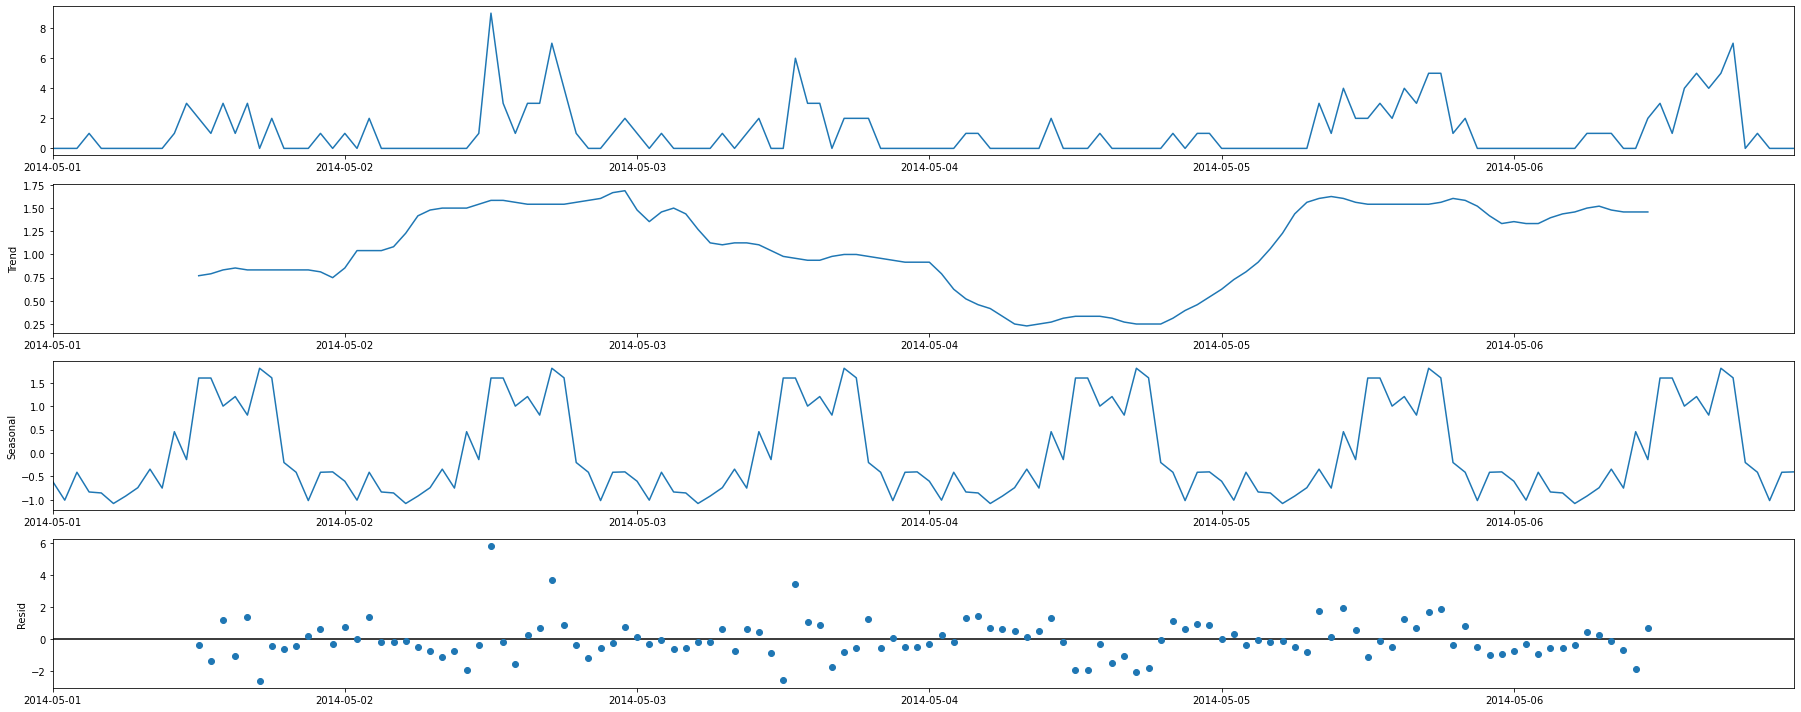

In [260]:
seasonal_decompose(hourly_sample, freq=None).plot()

In [570]:
#sample_station_df = df[df.station_name == "Zentralbibliothek / Münzstraße"]
sample_station_df = df.resample("H").sum()
train_size = 0.9
test_size = 0.1

## Monthly prediction

<AxesSubplot:xlabel='datetime'>

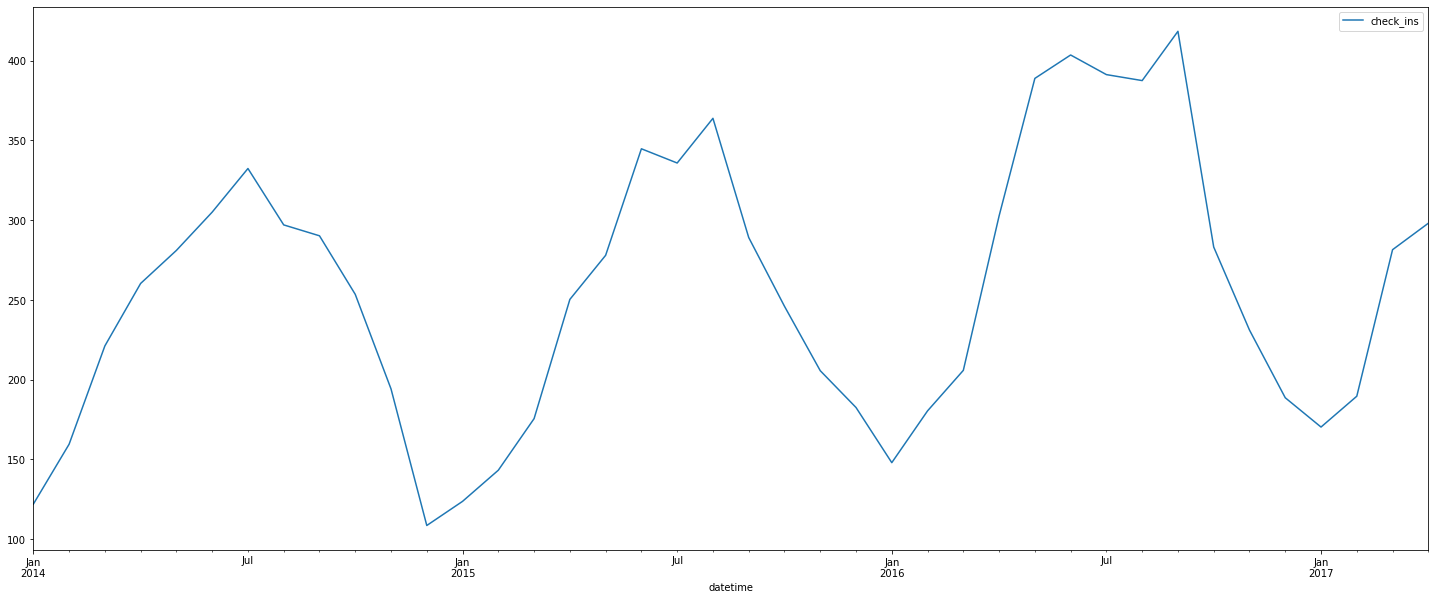

In [571]:
monthly_start_date = "2014-01-01"
monthly_end_date = "2017-04-30 21:59:59"
monthly_sample = sample_station_df[pd.Timestamp(monthly_start_date):pd.Timestamp(monthly_end_date)][["check_ins"]].resample("M").mean()
monthly_sample.plot()

In [573]:
monthly_train, monthly_test = train_test_split(
    monthly_sample, shuffle=False, train_size=train_size, test_size=test_size
)

monthly_auto = auto_arima(
    y = monthly_train,
    start_p = 0,
    start_q = 0,
    seasonal = True,
    m = 12
)

monthly_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -116.345
Date:                             Sun, 09 May 2021   AIC                            236.690
Time:                                     16:44:43   BIC                            238.961
Sample:                                          0   HQIC                           237.261
                                              - 36                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6968      0.273     -2.554      0.011      -1.231      -0.162
sigma2      1408.4410    482.944      2.916      0.004     461.888    2354.994
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 2.02
Prob(Q):                              0.69   Prob(JB):                         0.36
Heteroskedasticity (H):               1.94   Skew:                             0.65
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

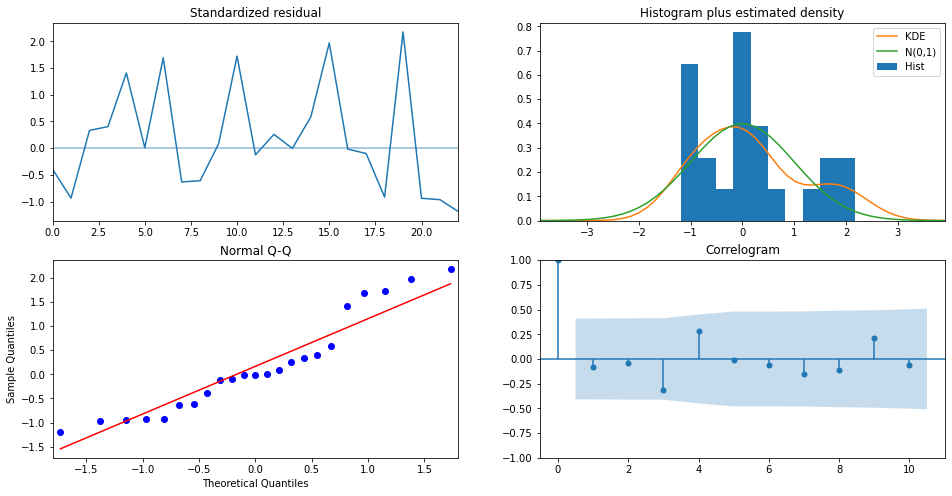

In [574]:
monthly_auto.plot_diagnostics(figsize=(16,8))
plt.show()

In [575]:
monthly_order = monthly_auto.get_params()["order"]
monthly_seasonal_order = monthly_auto.get_params()["seasonal_order"]
print("Order " + str(monthly_order))
print("Order " + str(monthly_seasonal_order))

Order (0, 1, 1)
Order (0, 1, 0, 12)


In [576]:
monthly_arima = ARIMA(monthly_train, order=monthly_order)
monthly_arima_fit = monthly_arima.fit()
monthly_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              check_ins   No. Observations:                   36
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -184.331
Date:                Sun, 09 May 2021   AIC                            372.662
Time:                        16:45:16   BIC                            375.772
Sample:                    01-31-2014   HQIC                           373.735
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2985      0.227      1.315      0.188      -0.146       0.743
sigma2      2192.2767    464.549      4.719      0.000    1281.778    3102.775
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 4.95
Prob(Q):                              0.48   Prob(JB):                         0.08
Heteroskedasticity (H):               2.21   Skew:                            -0.75
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.2359095415015286


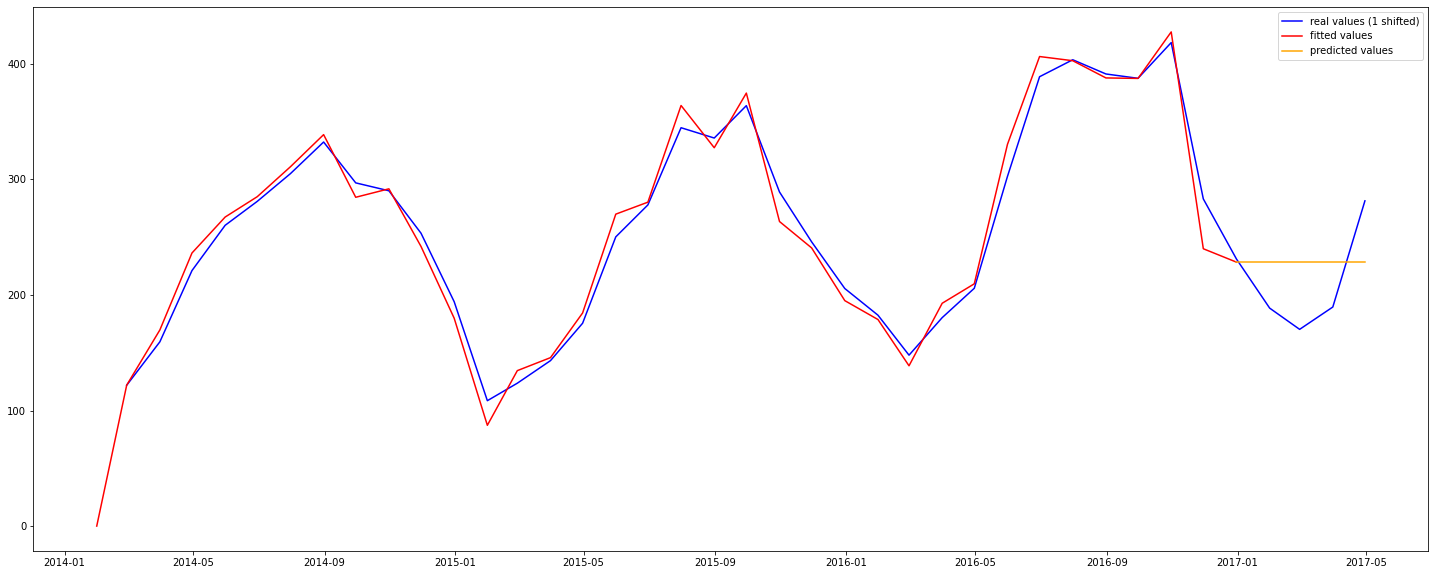

In [578]:
monthly_arima_predictions = monthly_arima_fit.predict(
    start=monthly_train.index.max(), end=monthly_test.index.max(), dynamic=True
).to_frame()
mape = mean_absolute_percentage_error(
    monthly_sample.loc[monthly_arima_predictions.index], monthly_arima_predictions
)
print("MAPE: %s" %(mape))
plt.plot(monthly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(monthly_arima_fit.fittedvalues, color="red", label="fitted values")
plt.plot(monthly_arima_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

In [579]:
monthly_sarimax = SARIMAX(monthly_train, order=monthly_order, seasonal_order=monthly_seasonal_order)
monthly_sarimax_fit = monthly_sarimax.fit()
monthly_sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           check_ins   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -116.345
Date:                             Sun, 09 May 2021   AIC                            236.690
Time:                                     16:46:05   BIC                            238.961
Sample:                                 01-31-2014   HQIC                           237.261
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6968      0.273     -2.554      0.011      -1.231      -0.162
sigma2      1408.4410    482.944      2.916      0.004     461.888    2354.994
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 2.02
Prob(Q):                              0.69   Prob(JB):                         0.36
Heteroskedasticity (H):               1.94   Skew:                             0.65
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.14970857769249288


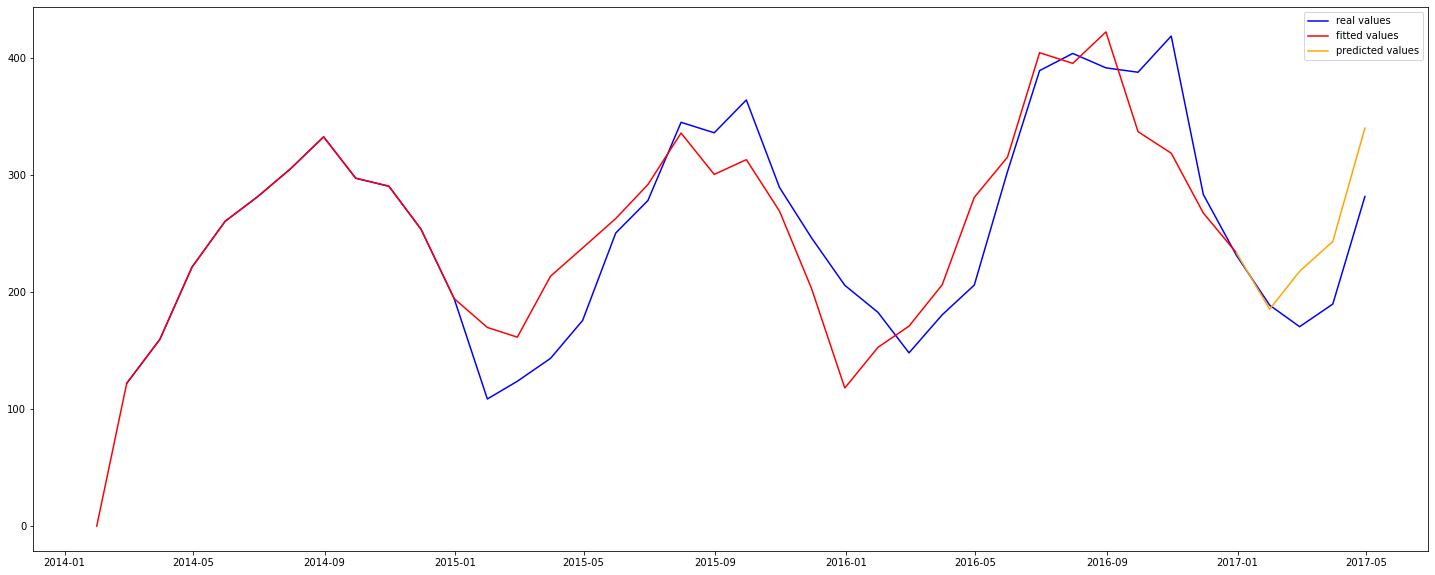

In [580]:
monthly_sarimax_predictions = monthly_sarimax_fit.predict(
    start=monthly_train.index.max(), end=monthly_test.index.max(), dynamic=False
).to_frame()
mape = mean_absolute_percentage_error(
    monthly_sample.loc[monthly_sarimax_predictions.index], monthly_sarimax_predictions
)
print("MAPE: %s" %(mape))
plt.plot(monthly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(monthly_sarimax_fit.fittedvalues, color="red", label="fitted values")
plt.plot(monthly_sarimax_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

## Weekly prediction

In [513]:
sample_station_df.index.min() # Wednesday

Timestamp('2014-01-01 00:00:00')

In [514]:
sample_station_df.index.max() # Monday

Timestamp('2017-05-15 11:00:00')

<AxesSubplot:xlabel='datetime'>

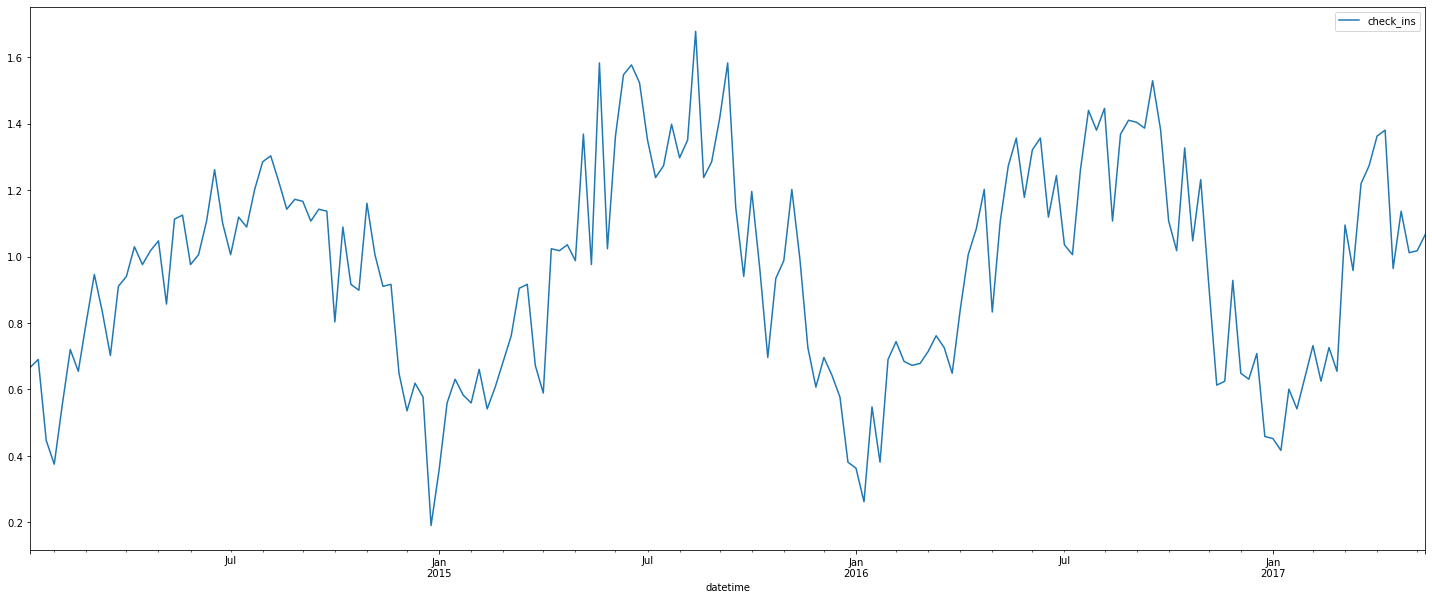

In [515]:
weekly_start_date = "2014-01-07" # first Sunday morning
weekly_end_date = "2017-05-14 21:59:59" # last Monday evening
weekly_sample = sample_station_df[pd.Timestamp(weekly_start_date):pd.Timestamp(weekly_end_date)][["check_ins"]].resample("W").mean()
weekly_sample.plot()

In [557]:
weekly_train, weekly_test = train_test_split(weekly_sample, shuffle=False, train_size=train_size, test_size=test_size)

weekly_auto = auto_arima(
    y = weekly_train,
    start_p = 0,
    start_q = 0,
    seasonal = True,
    trace = True,
    m = 52
)

weekly_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=7.39 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=92.644, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-83.647, Time=2.77 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=-20.256, Time=2.22 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=452.250, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=-85.147, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=-83.561, Time=2.10 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=7.93 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=-93.267, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=-92.301, Time=3.75 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=-92.115, Time=3.34 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=10.19 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=-94.434, Time=0.05 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=-95.049, Time=6.44 sec
 ARIMA(3,0,0)(2,0,0)[52] intercept   : AIC=in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  157
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 52)   Log Likelihood                  53.524
Date:                            Sun, 09 May 2021   AIC                            -95.049
Time:                                    16:34:19   BIC                            -76.711
Sample:                                         0   HQIC                           -87.601
                                            - 157                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0939      0.048      1.963      0.050       0.000       0.188
ar.L1          0.5385      0.078      6.943      0.000       0.386       0.690
ar.L2          0.1575      0.070      2.247      0.025       0.020       0.295
ar.L3          0.1815      0.081      2.248      0.025       0.023       0.340
ar.S.L52       0.1627      0.096      1.694      0.090      -0.026       0.351
sigma2         0.0291      0.004      8.272      0.000       0.022       0.036
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.86   Prob(JB):                         0.94
Heteroskedasticity (H):               1.54   Skew:                             0.00
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

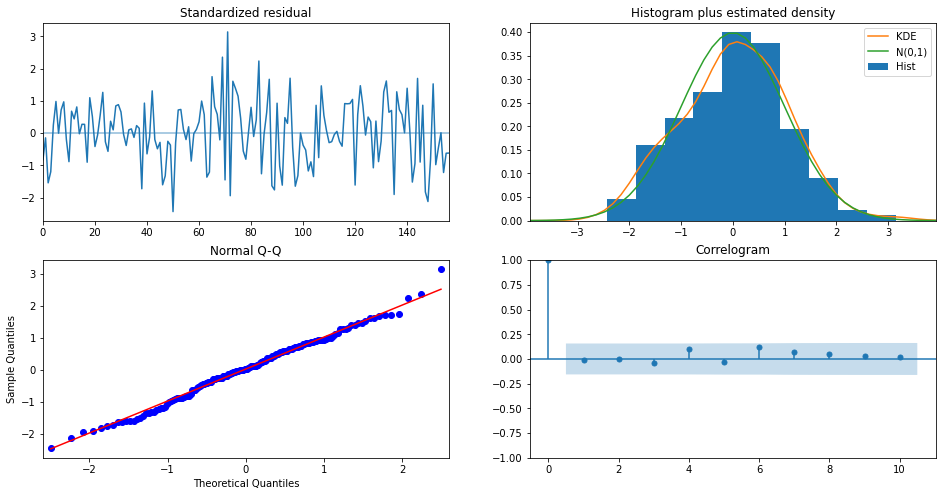

In [558]:
weekly_auto.plot_diagnostics(figsize=(16,8))
plt.show()

In [561]:
weekly_order = weekly_auto.get_params()["order"]
weekly_seasonal_order = weekly_auto.get_params()["seasonal_order"]
print("Order " + str(weekly_order))
print("Seasonal order " + str(weekly_seasonal_order))

Order (3, 0, 0)
Seasonal order (1, 0, 0, 52)


In [562]:
weekly_arima = ARIMA(weekly_train, order=weekly_order)
weekly_arima_fit = weekly_arima.fit()
weekly_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              check_ins   No. Observations:                  157
Model:                 ARIMA(3, 0, 0)   Log Likelihood                  52.217
Date:                Sun, 09 May 2021   AIC                            -94.434
Time:                        16:42:59   BIC                            -79.152
Sample:                    01-12-2014   HQIC                           -88.227
                         - 01-08-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9024      0.140      6.435      0.000       0.628       1.177
ar.L1          0.5902      0.073      8.114      0.000       0.448       0.733
ar.L2          0.1641      0.073      2.263      0.024       0.022       0.306
ar.L3          0.1428      0.080      1.791      0.073      -0.013       0.299
sigma2         0.0298      0.004      8.127      0.000       0.023       0.037
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.90   Prob(JB):                         0.87
Heteroskedasticity (H):               1.53   Skew:                            -0.01
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.27265224575973773


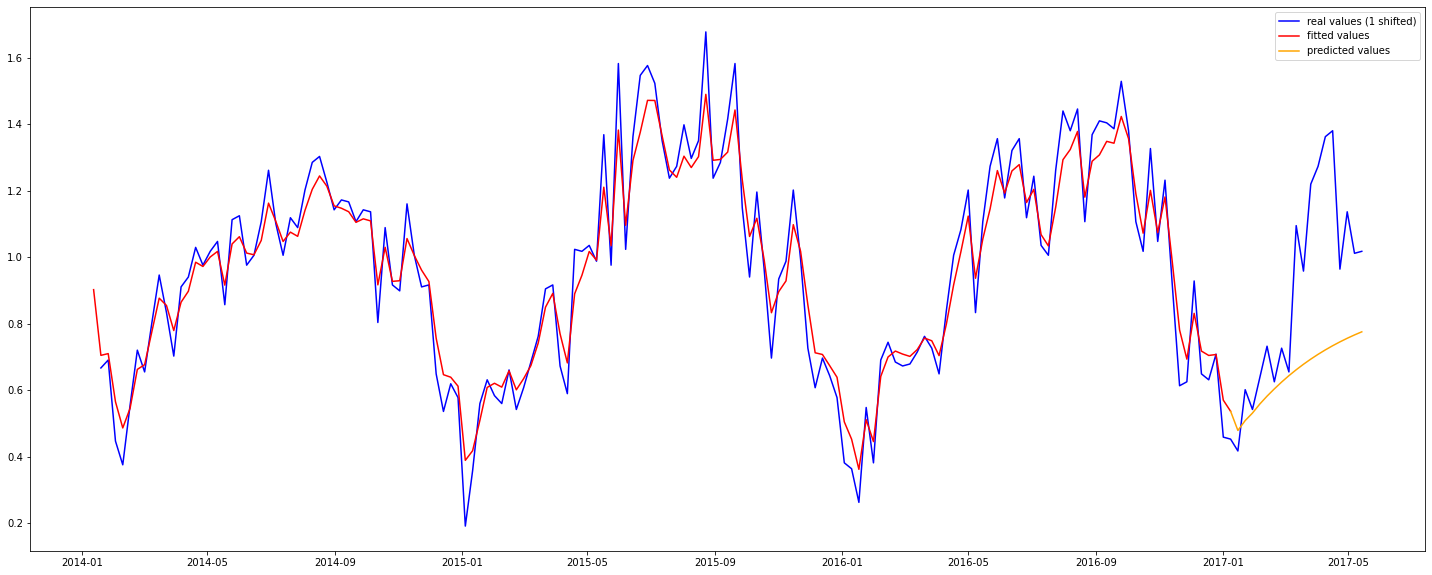

In [609]:
weekly_arima_predictions = weekly_arima_fit.predict(
    start=weekly_train.index.max(), end=weekly_test.index.max(), dynamic=False
).to_frame()
mape = mean_absolute_percentage_error(
    weekly_sample.loc[weekly_arima_predictions.index], weekly_arima_predictions
)
print("MAPE: %s" %(mape))
plt.plot(weekly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(weekly_arima_fit.fittedvalues, color="red", label="fitted values")
plt.plot(weekly_arima_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

In [565]:
weekly_sarimax = SARIMAX(weekly_train, order=weekly_order, seasonal_order=weekly_seasonal_order)
weekly_sarimax_fit = weekly_sarimax.fit()
weekly_sarimax_fit.summary()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          check_ins   No. Observations:                  157
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 52)   Log Likelihood                  50.136
Date:                            Sun, 09 May 2021   AIC                            -90.271
Time:                                    16:43:23   BIC                            -74.990
Sample:                                01-12-2014   HQIC                           -84.065
                                     - 01-08-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5849      0.075      7.758      0.000       0.437       0.733
ar.L2          0.1832      0.068      2.677      0.007       0.049       0.317
ar.L3          0.2162      0.080      2.699      0.007       0.059       0.373
ar.S.L52       0.1323      0.096      1.384      0.166      -0.055       0.320
sigma2         0.0301      0.004      8.093      0.000       0.023       0.037
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.74   Prob(JB):                         0.79
Heteroskedasticity (H):               1.63   Skew:                            -0.11
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.4511693340850981


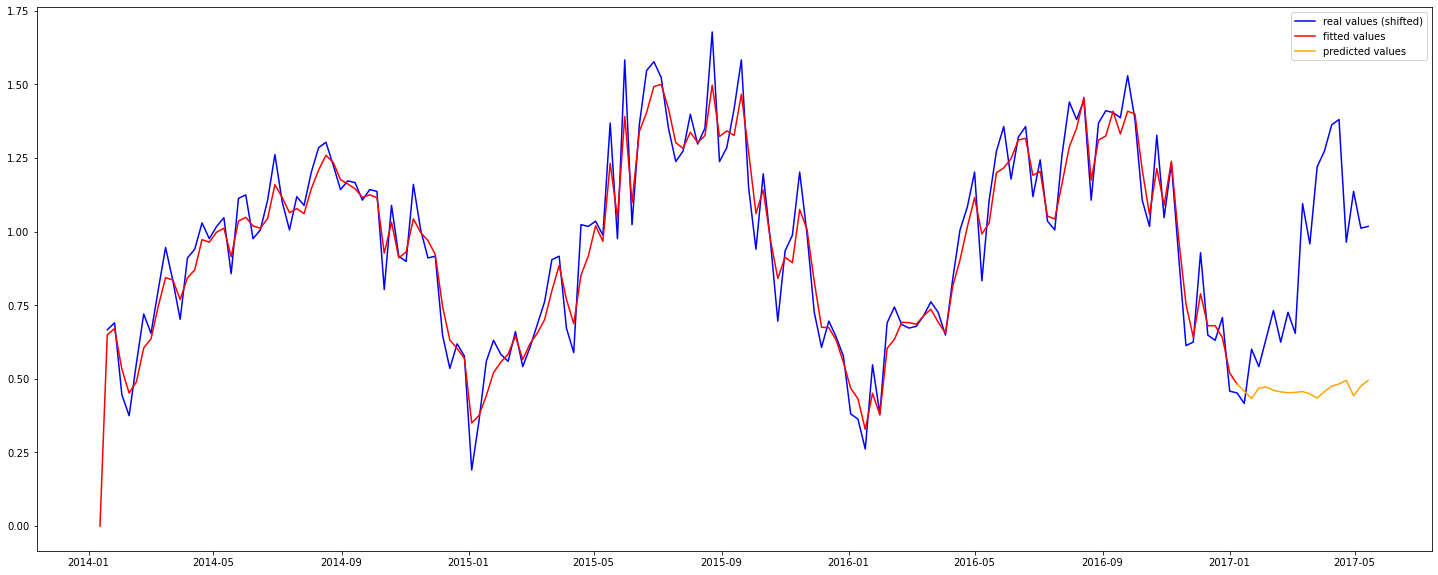

In [566]:
weekly_sarimax_predictions = weekly_sarimax_fit.predict(
    start=weekly_train.index.max(), end=weekly_test.index.max(), dynamic=False
).to_frame()
mape = mean_absolute_percentage_error(
    weekly_sample.loc[weekly_sarimax_predictions.index], weekly_sarimax_predictions
)
print("MAPE: %s" %(mape))
plt.plot(weekly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(weekly_sarimax_fit.fittedvalues, color="red", label="fitted values")
plt.plot(weekly_sarimax_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

## Hourly predictions

<AxesSubplot:xlabel='datetime'>

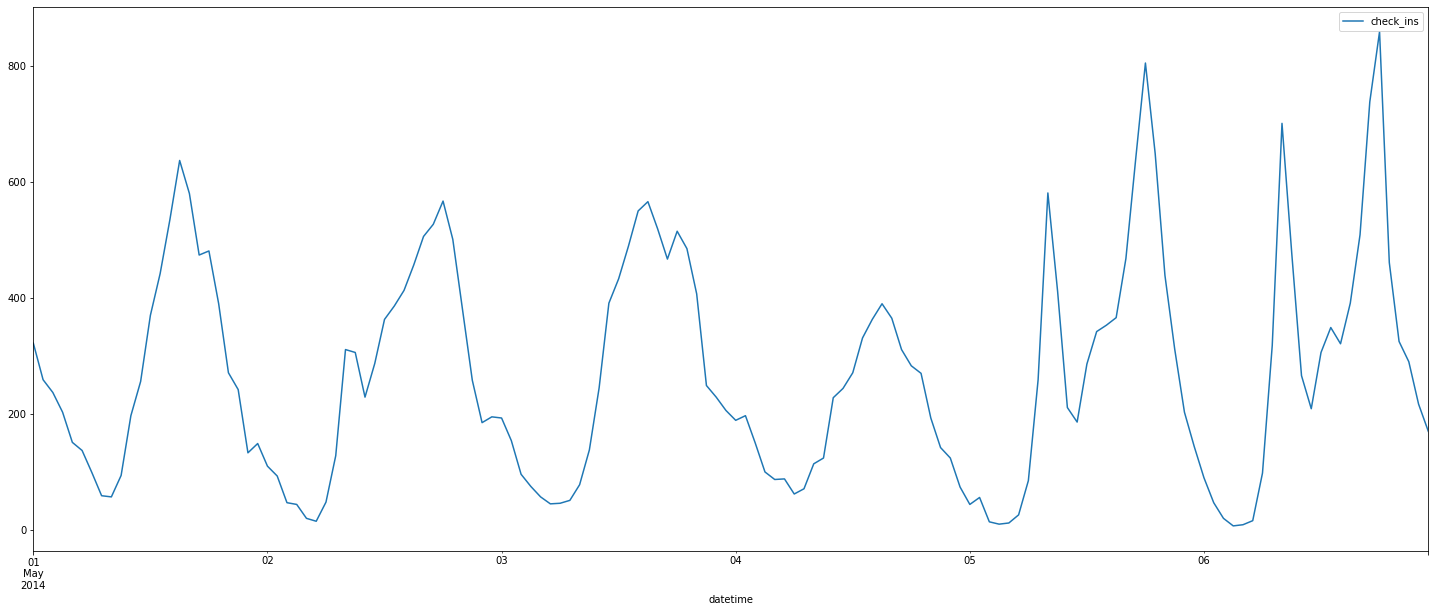

In [581]:
hourly_start_date = "2014-05-01"
hourly_end_date = "2014-05-06 23:59:59"
hourly_sample = sample_station_df[pd.Timestamp(hourly_start_date):pd.Timestamp(hourly_end_date)][["check_ins"]]
hourly_sample.plot()

In [582]:
hourly_train, hourly_test = train_test_split(
    hourly_sample, shuffle=False, train_size=train_size, test_size=test_size
)

hourly_auto = auto_arima(
    y = hourly_train,
    start_p = 0,
    start_q = 0,
    seasonal = True,
    m = 24
)

hourly_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  129
Model:             SARIMAX(4, 0, 1)x(0, 0, 1, 24)   Log Likelihood                -713.205
Date:                            Sun, 09 May 2021   AIC                           1442.410
Time:                                    16:49:23   BIC                           1465.288
Sample:                                         0   HQIC                          1451.706
                                            - 129                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.0577     13.609      1.547      0.122      -5.615      47.730
ar.L1          2.1702      0.231      9.407      0.000       1.718       2.622
ar.L2         -1.9003      0.361     -5.261      0.000      -2.608      -1.192
ar.L3          0.9553      0.264      3.616      0.000       0.437       1.473
ar.L4         -0.2978      0.118     -2.513      0.012      -0.530      -0.066
ma.L1         -0.7302      0.232     -3.152      0.002      -1.184      -0.276
ma.S.L24       0.6278      0.105      5.962      0.000       0.421       0.834
sigma2      3303.3018    381.991      8.648      0.000    2554.614    4051.990
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.12
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.44   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

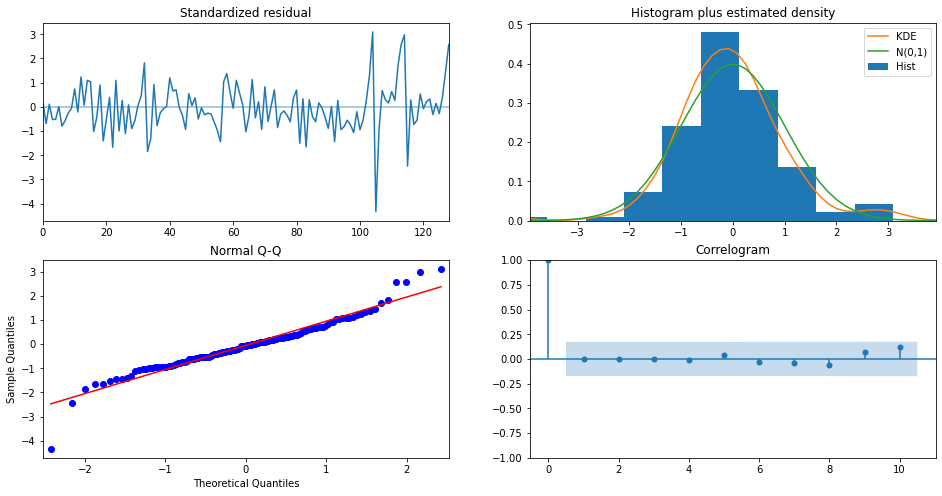

In [596]:
hourly_auto.plot_diagnostics(figsize=(16,8))
plt.show()

In [612]:
hourly_order = hourly_auto.get_params()["order"]
hourly_seasonal_order = hourly_auto.get_params()["seasonal_order"]
print("Order " + str(hourly_order))
print("Seasonal order " + str(hourly_seasonal_order))

Order (4, 0, 1)
Seasonal order (0, 0, 1, 24)


In [600]:
hourly_arima = ARIMA(hourly_train, order=hourly_order)
hourly_arima_fit = hourly_arima.fit()
hourly_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              check_ins   No. Observations:                  129
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -719.482
Date:                Sun, 09 May 2021   AIC                           1452.964
Time:                        16:57:49   BIC                           1472.982
Sample:                    05-01-2014   HQIC                          1461.098
                         - 05-06-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        266.5494     20.954     12.720      0.000     225.479     307.619
ar.L1          2.2545      0.143     15.712      0.000       1.973       2.536
ar.L2         -2.0352      0.281     -7.254      0.000      -2.585      -1.485
ar.L3          1.0296      0.287      3.582      0.000       0.466       1.593
ar.L4         -0.3248      0.146     -2.228      0.026      -0.611      -0.039
ma.L1         -0.8100      0.131     -6.205      0.000      -1.066      -0.554
sigma2      3979.6063    314.634     12.648      0.000    3362.936    4596.277
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               199.18
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.89   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.9460928772282592


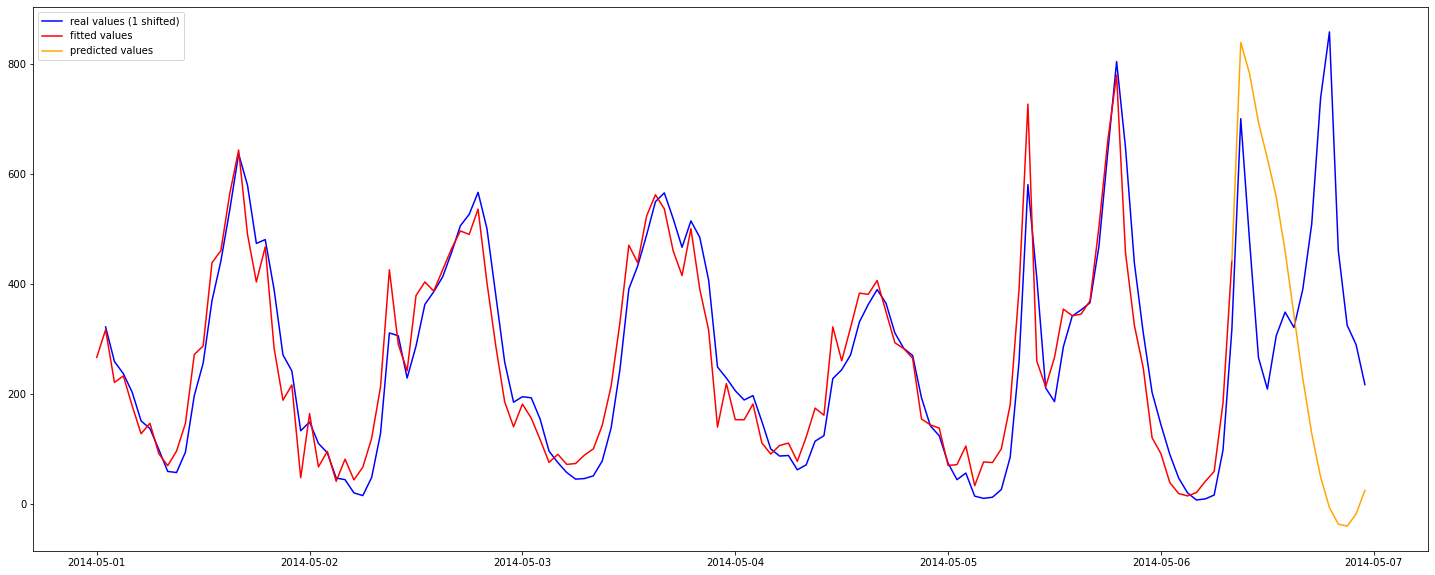

In [611]:
hourly_arima_predictions = hourly_arima_fit.predict(
    start=hourly_train.index.max(), end=hourly_test.index.max(), dynamic=False
).to_frame()
mape = mean_absolute_percentage_error(
    hourly_sample.loc[hourly_arima_predictions.index], hourly_arima_predictions
)
print("MAPE: %s" %(mape))
plt.plot(hourly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(hourly_arima_fit.fittedvalues, color="red", label="fitted values")
plt.plot(hourly_arima_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

In [598]:
hourly_sarimax = SARIMAX(hourly_train, order=hourly_order, seasonal_order=hourly_seasonal_order)
hourly_sarimax_fit = hourly_sarimax.fit()
hourly_sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          check_ins   No. Observations:                  129
Model:             SARIMAX(4, 0, 1)x(0, 0, 1, 24)   Log Likelihood                -721.707
Date:                            Sun, 09 May 2021   AIC                           1457.415
Time:                                    16:56:34   BIC                           1477.434
Sample:                                05-01-2014   HQIC                          1465.549
                                     - 05-06-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7981      1.125      1.599      0.110      -0.406       4.002
ar.L2         -1.2913      1.740     -0.742      0.458      -4.701       2.119
ar.L3          0.6216      0.961      0.647      0.518      -1.262       2.505
ar.L4         -0.1738      0.297     -0.585      0.559      -0.756       0.409
ma.L1         -0.2381      1.127     -0.211      0.833      -2.447       1.971
ma.S.L24       0.7961      0.140      5.706      0.000       0.523       1.070
sigma2      3463.5898    553.877      6.253      0.000    2378.012    4549.168
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                35.05
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -0.35
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE: 0.1705036551368605


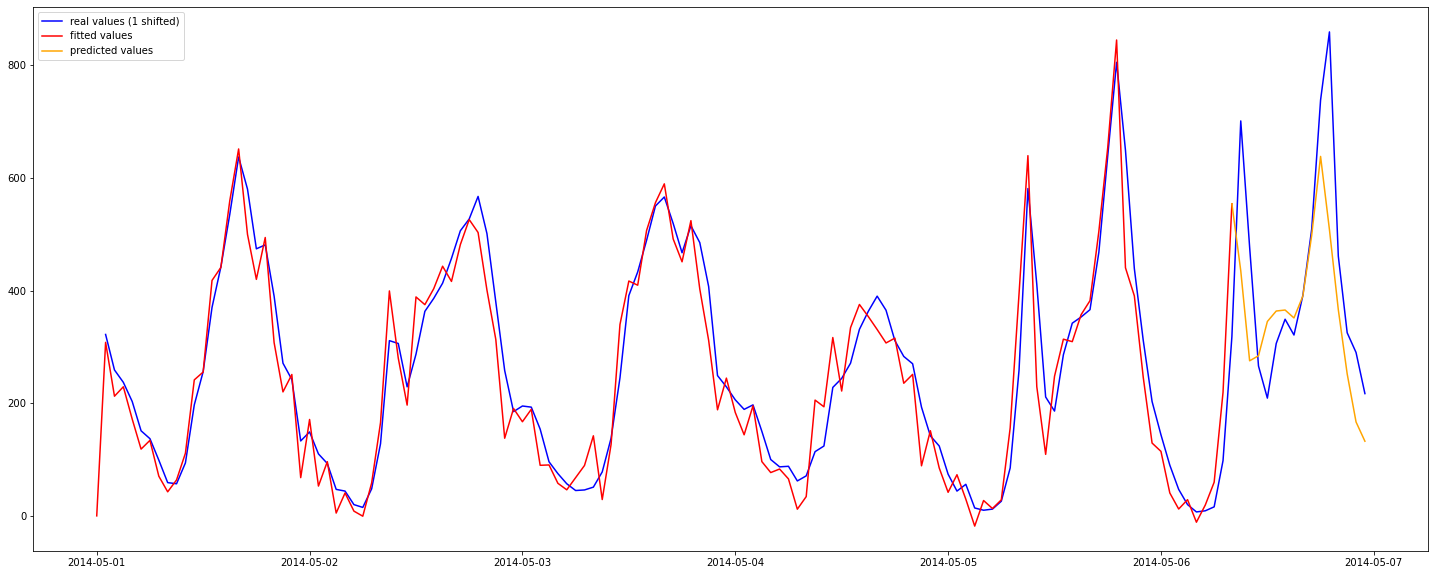

In [610]:
hourly_sarimax_predictions = hourly_sarimax_fit.predict(
    start=hourly_train.index.max(), end=hourly_test.index.max(), dynamic=True
).to_frame()
mape = mean_absolute_percentage_error(
    hourly_sample.loc[hourly_sarimax_predictions.index], hourly_sarimax_predictions
)
print("MAPE: %s" %(mape))
plt.plot(hourly_sample.shift(1), color="blue", label="real values (1 shifted)")
plt.plot(hourly_sarimax_fit.fittedvalues, color="red", label="fitted values")
plt.plot(hourly_sarimax_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()